# PedidosYa Product Recommender System using TFRS

## Installations

In [ ]:
!pip install -q tensorflow-recommenders==0.6.0
!pip install -q scann==1.2.3

## Git

In [ ]:
!git clone -b T308050 https://github.com/sparsh-ai/general-recsys.git

In [ ]:
%cd general-recsys

/content/general-recsys


## Imports

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import sys
import os
import logging
import pandas as pd
import pandas_gbq
from os import path as osp
from pathlib import Path

from typing import Dict, Text

import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery
from google.cloud.bigquery_storage_v1beta1 import BigQueryStorageClient

import tensorflow as tf
import tensorflow_recommenders as tfrs

In [ ]:
from google.colab import auth
from google.colab import drive

auth.authenticate_user()
print('Authenticated')

IN_COLAB = True

Authenticated


## Params

In [ ]:
class Args:
    datapath_bronze = '/content'
    datapath_silver = '/content'

args = Args()

## Logger

In [ ]:
logging.basicConfig(stream=sys.stdout,
                    level = logging.DEBUG,
                    format='%(asctime)s [%(levelname)s] : %(message)s',
                    datefmt='%d-%b-%y %H:%M:%S')

logger = logging.getLogger('Logger')

## Utils

## Dataset

### Define SQL queries

**interactions.sql**

```sql
CREATE OR REPLACE TABLE `peya-food-and-groceries.user_fiorella_dirosario.order_sep2020_sep2021` AS
SELECT
    o.user.id as user_id
     , o.is_pre_order
     ,o.pickup
     ,o.discount_type
     , o.order_id
     , o.registered_at as timestamp
FROM `peya-bi-tools-pro.il_core.fact_orders` o
WHERE registered_date BETWEEN "2020-09-01" AND "2021-09-30"
  AND o.business_type.business_type_id = 2
  AND o.order_status = "CONFIRMED"
  AND o.country.country_id = 3
```

**order_details.sql**

```sql
CREATE OR REPLACE TABLE `peya-food-and-groceries.user_fiorella_dirosario.order_details_sep2020_sep2021` AS
SELECT
    o.order_id
     , CASE WHEN SPLIT(d.integration_code, "-")[SAFE_OFFSET(0)] IN ("D", "P") THEN SPLIT(d.integration_code, "-")[SAFE_OFFSET(2)]
            WHEN SPLIT(d.integration_code, "-")[SAFE_OFFSET(0)] IN ("S", "G") THEN SPLIT(d.integration_code, "-")[SAFE_OFFSET(3)]
            ELSE dp.gtin
    END as gtin

     , CASE WHEN SPLIT(d.integration_code, "-")[SAFE_OFFSET(0)] IN ("D", "P", "S", "G") THEN 1
            WHEN dp.gtin IS NOT NULL THEN 1
            ELSE 0
    END as has_gtin
     , d.integration_code
     , d.product.product_id
     , d.product_name
     , o.restaurant.id as partner_id
     , o.restaurant.name as partner_name
FROM `peya-bi-tools-pro.il_core.fact_orders` o
   , UNNEST(details) d
         LEFT JOIN `peya-bi-tools-pro.il_core.dim_product` dp ON dp.id = d.product.product_id
WHERE registered_date BETWEEN "2020-09-01" AND "2021-09-30"
  AND o.business_type.business_type_id = 2
  AND o.order_status = "CONFIRMED"
  AND o.country.country_id = 3
```

**product_attributes.sql**

```sql
CREATE OR REPLACE TABLE `peya-food-and-groceries.user_fiorella_dirosario.product_attributes_sep2020_sep2021` AS
    WITH info AS (
        SELECT
            od.gtin as gtin
             , MIN(dp.date_created) as date_created
             , MIN(brand_id) as brand_id
             , MIN(cb.name) as brand_name
             , MIN(cb.group_id) as brand_group_id
             , MIN(cbg.name) as brand_group_name
             , MIN(category_id) as category_id
             , MIN(cc.name) as category_name
        FROM `peya-food-and-groceries.user_fiorella_dirosario.order_details_sep2020_sep2021` od
                 INNER JOIN `peya-bi-tools-pro.il_core.dim_product` dp ON dp.id = od.product_id
                 LEFT JOIN `peya-data-origins-pro.cl_catalogue.product` cp ON cp.gtin = od.gtin
                 LEFT JOIN `peya-data-origins-pro.cl_catalogue.brand` cb ON cb.id = cp.brand_id
                 LEFT JOIN `peya-data-origins-pro.cl_catalogue.category` cc ON cc.id = cp.category_id

                 LEFT JOIN `peya-data-origins-pro.cl_catalogue.brand_group` cbg ON cbg.id = cb.group_id
        GROUP BY 1
    )
    SELECT
        gtin
         , category_id
         , category_name
         , brand_id
         , brand_name
         , brand_group_id
         , brand_group_name
         , DATE_DIFF("2021-09-30", DATE(date_created), DAY) as age
    FROM info
```

**user_attributes.sql**

```sql
CREATE OR REPLACE TABLE `peya-food-and-groceries.user_fiorella_dirosario.user_attributes_sep2020_sep2021` AS
    WITH most_freq_attr AS (
        SELECT
            user.id as user_id
             , APPROX_TOP_COUNT(o.city.city_id, 1)[OFFSET(0)].value AS most_frequent_city
             , APPROX_TOP_COUNT(o.application, 1)[OFFSET(0)].value AS most_frequent_platform
        FROM `peya-bi-tools-pro.il_core.fact_orders` o
        WHERE registered_date BETWEEN "2020-09-01" AND "2021-09-30"
          AND o.order_status = "CONFIRMED"
          AND o.country.country_id = 3
        GROUP BY 1
    )
       , users_period AS
        (
            SELECT
                DISTINCT
                user_id
            FROM `peya-food-and-groceries.user_fiorella_dirosario.user_order_sep2020_sep2021`
        )
    SELECT
        up.user_id
         , freq.most_frequent_city as city_id
         , freq.most_frequent_platform as platform
         , us.segment
         ,last_order_date
         ,days_from_first_order
    FROM users_period up
             LEFT JOIN most_freq_attr freq ON freq.user_id = up.user_id
             LEFT JOIN `peya-growth-and-onboarding.automated_tables_reports.user_segments` us ON us.user_id = up.user_id
        AND DATE(us.date) = "2021-09-30"
```

**Query for 2-tower model**

We use the interaction between user ans product for user that has at least 2 orders.

In [ ]:
MINIMUM_PRODUCTS = 5
MINIMUM_ORDERS = 2
data_project_id = "peya-food-and-groceries"
data_dataset_id = "user_fiorella_dirosario"
data_table_orders = "order_sep2020_sep2021"
data_table_order_details = "order_details_sep2020_sep2021"
data_table_users = "attributes_sep2020_sep2021"
data_table_products = "product_attributes_sep2020_sep2021"

interaction_query_train = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT gtin) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.gtin IS NOT NULL
      AND od.has_gtin = 1
    GROUP BY 1
)
SELECT DISTINCT
    CAST(uo.user_id AS STRING) AS user_id
  , CAST(od.gtin AS STRING) AS product_id
  --, uo.order_id
  --, uo.timestamp
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
ON uo.order_id = od.order_id
LEFT JOIN products_by_user pbu ON pbu.user_id = uo.user_id
WHERE uo.user_id IS NOT NULL
  AND od.gtin IS NOT NULL
  AND od.has_gtin = 1
  AND cant_products >= minimum_products
  AND cant_orders >= minimum_orders
  AND uo.order_id != pbu.last_order_id 
"""

interaction_query_test = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT gtin) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.gtin IS NOT NULL
      AND od.has_gtin = 1
    GROUP BY 1
)
SELECT DISTINCT
    CAST(uo.user_id AS STRING) AS user_id
  , CAST(od.gtin AS STRING) AS product_id
  --, uo.order_id
  --, uo.timestamp
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
ON
  uo.order_id = od.order_id
LEFT JOIN 
  products_by_user pbu 
ON 
  pbu.user_id = uo.user_id
WHERE 
  uo.user_id IS NOT NULL
  AND od.gtin IS NOT NULL
  AND od.has_gtin = 1
  AND cant_products >= minimum_products
  AND cant_orders >= minimum_orders
  AND uo.order_id = pbu.last_order_id 
"""

product_query = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};


WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT od.gtin) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.gtin IS NOT NULL
      AND od.has_gtin = 1
    GROUP BY 1
    HAVING 
      cant_products >= minimum_products AND cant_orders >= minimum_orders
)
, products AS (
  SELECT DISTINCT
    od.gtin
  FROM
    `{data_project_id}.{data_dataset_id}.{data_table_order_details}` od
  JOIN 
    `{data_project_id}.{data_dataset_id}.{data_table_orders}` uo ON uo.order_id = od.order_id
  JOIN 
    products_by_user pbu ON pbu.user_id = uo.user_id
  WHERE od.gtin IS NOT NULL AND od.has_gtin = 1
)

SELECT 
    CAST(pa.gtin AS STRING) AS product_id
  , IF(pa.category_id IS NULL, "", CAST(pa.category_id AS STRING))  AS category_id
  , IF(pa.brand_id IS NULL, "", CAST(pa.brand_id AS STRING)) AS brand_id
  , CAST(pa.age AS STRING) AS age
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_products}` pa
JOIN products p ON p.gtin = pa.gtin
"""

user_query = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
    uo.user_id
    , COUNT(DISTINCT gtin) as cant_products
    , COUNT(DISTINCT uo.order_id) as cant_orders
    , MAX(uo.order_id) as last_order_id
    FROM 
    `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
    `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON uo.order_id = od.order_id  
    WHERE uo.user_id IS NOT NULL
    AND od.gtin IS NOT NULL
    AND od.has_gtin = 1
    GROUP BY 1
)
SELECT 
    CAST(ua.user_id AS STRING) AS user_id
  , CAST(ua.city_id AS STRING) AS city_id
  , ua.platform
  , IF(ua.segment IS NULL, "Not set", ua.segment) AS segment
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_users}` ua
LEFT JOIN products_by_user pbu ON pbu.user_id = ua.user_id
WHERE cant_products >= minimum_products
      AND cant_orders >= minimum_orders
"""

**Query for 2-tower model with context**

In [ ]:
MINIMUM_PRODUCTS = 5
MINIMUM_ORDERS = 2
data_project_id = "peya-food-and-groceries"
data_dataset_id = "user_fiorella_dirosario"
data_table_orders = "order_sep2020_sep2021"
data_table_order_details = "order_details_sep2020_sep2021"
data_table_users = "attributes_sep2020_sep2021"
data_table_products = "product_attributes_sep2020_sep2021"

interaction_query_train = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT gtin) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.gtin IS NOT NULL
      AND od.has_gtin = 1
    GROUP BY 1
)
SELECT DISTINCT
    uo.user_id
  , EXTRACT(DAYOFWEEK FROM uo.timestamp) as dow
  , EXTRACT(hour FROM uo.timestamp) as hod
  , od.gtin
  , IF(od.partner_id IS NULL, -1, od.partner_id) AS partner_id
  , IF(pa.category_id IS NULL, -1, pa.category_id) AS category_id
  , IF(pa.brand_id IS NULL, -1, pa.brand_id) AS brand_id
  , IF(pa.age IS NULL, 1000, pa.age) as age
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
ON 
  uo.order_id = od.order_id
LEFT JOIN 
  products_by_user pbu 
ON pbu.user_id = uo.user_id
LEFT JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_products}` as pa
ON 
  pa.gtin = od.gtin
WHERE uo.user_id IS NOT NULL
  AND od.gtin IS NOT NULL
  AND od.has_gtin = 1
  AND cant_products >= minimum_products
  AND cant_orders >= minimum_orders
  AND uo.order_id != pbu.last_order_id 
"""

user_query_query_test = f"""
DECLARE minimum_products INT64;
DECLARE minimum_orders INT64;

SET minimum_products = {MINIMUM_PRODUCTS};
SET minimum_orders = {MINIMUM_ORDERS};

WITH products_by_user AS (
    SELECT
        uo.user_id
      , COUNT(DISTINCT gtin) as cant_products
      , COUNT(DISTINCT uo.order_id) as cant_orders
      , MAX(uo.order_id) as last_order_id
    FROM 
      `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
    JOIN 
      `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
    ON 
      uo.order_id = od.order_id  
    WHERE 
      uo.user_id IS NOT NULL
      AND od.gtin IS NOT NULL
      AND od.has_gtin = 1
    GROUP BY 1
)
SELECT DISTINCT
    uo.user_id
  , EXTRACT(DAYOFWEEK FROM uo.timestamp) as dow
  , EXTRACT(hour FROM uo.timestamp) as hod
FROM 
  `{data_project_id}.{data_dataset_id}.{data_table_orders}` as uo
JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_order_details}` as od
ON 
  uo.order_id = od.order_id
LEFT JOIN 
  products_by_user pbu 
ON pbu.user_id = uo.user_id
LEFT JOIN 
  `{data_project_id}.{data_dataset_id}.{data_table_products}` as pa
ON 
  pa.gtin = od.gtin
WHERE uo.user_id IS NOT NULL
  AND od.gtin IS NOT NULL
  AND od.has_gtin = 1
  AND cant_products >= minimum_products
  AND cant_orders >= minimum_orders
  AND uo.order_id = pbu.last_order_id 
"""

### Fetching data from Google BigQuery

In [ ]:
project_id = "peya-data-analyt-factory-stg"  # ["peya-data-analyt-factory-stg", "peya-food-and-groceries", "peya-growth-and-onboarding"]
client = bigquery.client.Client(project=project_id)
bq_storage_client = BigQueryStorageClient()

interactions_train = (
    client.query(interaction_query_train)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
)

interactions_test = (
    client.query(interaction_query_test)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
)

users = (
    client.query(user_query)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
)
products = (
    client.query(product_query)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
)

user_ids = users["user_id"].unique().tolist()
product_ids = products["product_id"].unique().tolist()

In [ ]:
interactions_train_ds = tf.data.Dataset.from_tensor_slices(interactions_train.to_dict(orient="list"))
interactions_train_ds = interactions_train_ds.map(lambda x: {"user_id": x["user_id"], "product_id": x["product_id"]})

users_ds = tf.data.Dataset.from_tensor_slices(users.to_dict(orient="list"))
products_ds = tf.data.Dataset.from_tensor_slices(products.to_dict(orient="list"))

tf.random.set_seed(42)
interactions_train_ds = interactions_train_ds.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

for k in interactions_train_ds.take(1).as_numpy_iterator():
    print(k)
for k in products_ds.take(1).as_numpy_iterator():
    print(k)
for k in users_ds.take(1).as_numpy_iterator():
    print(k)

{'user_id': b'22085557', 'product_id': b'07790480008261'}
{'product_id': b'07793940054006', 'category_id': b'125', 'brand_id': b'2761', 'age': b'526'}
{'user_id': b'23789601', 'city_id': b'572', 'platform': b'ANDROID', 'segment': b'Not set'}


In [ ]:
products_ds = products_ds.map(lambda x: x["product_id"])
users_ds = users_ds.map(lambda x: x["user_id"])

In [ ]:
project_id = "peya-growth-and-onboarding"  # ["peya-data-analyt-factory-stg", "peya-food-and-groceries", "peya-growth-and-onboarding"]
client = bigquery.client.Client(project=project_id)
bq_storage_client = BigQueryStorageClient()

interactions_train = (
    client.query(interaction_query_train)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
        .fillna(-1)
)

query_test = (
    client.query(user_query_query_test)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
        .fillna(-1)
)

In [ ]:
if not os.path.exists("data"):
    os.makedirs("data")

In [ ]:
query_fields = [
    'user_id',
    'dow',
    'hod',
]
candidate_fields = [
    'gtin',
    # 'product_name',
    # 'partner_id',
    # 'partner_name',
    'category_id',
    'brand_id',
    # 'age'
]

In [ ]:
step = 100_000
total_samples = len(interactions_train)
for k in range(0, total_samples, step):
    interactions_train.loc[k:k + step, query_fields + candidate_fields].to_csv(f"data/interactions_{k}.csv",
                                                                               index=False)

In [ ]:
queries = interactions_train[query_fields].drop_duplicates()
candidates = interactions_train[candidate_fields].drop_duplicates()

user_ids = queries['user_id'].unique()
user_ids = user_ids[user_ids >= 0]

gtin_ids = candidates['gtin'].unique()
#product_names = candidates['product_name'].unique()
category_ids = candidates['category_id'].unique()
category_ids = category_ids[category_ids >= 0]
brand_ids = candidates['brand_id'].unique()
brand_ids = brand_ids[brand_ids >= 0]
# candidates['age'].mean()
# candidates['age'].var()
candidates

,gtin,category_id,brand_id
0,07613035494800,176,2736
1,07792900092706,117,8735
2,07798162980768,140,8735
3,07791078022713,87,2248
4,07613034416926,177,2059
...,...,...,...
17072237,7791720016275,-1,-1
17072602,7613032603281,-1,-1
17076347,77961167,-1,-1
17083419,7792319969149,-1,-1


In [ ]:
tf.random.set_seed(42)
interactions_train_ds = tf.data.experimental.make_csv_dataset(
    "data/interactions*.csv",
    batch_size=8192,
    num_epochs=1,
    num_parallel_reads=20,
    shuffle_buffer_size=10000
).prefetch(tf.data.AUTOTUNE).cache().shuffle(100000, seed=42)
users_ds = tf.data.Dataset.from_tensor_slices(queries.to_dict(orient="list"))
products_ds = tf.data.Dataset.from_tensor_slices(candidates.to_dict(orient="list"))

for k in products_ds.take(1).as_numpy_iterator():
    print(k)
for k in users_ds.take(1).as_numpy_iterator():
    print(k)

{'gtin': b'07613035494800', 'category_id': 176, 'brand_id': 2736}
{'user_id': 19431540, 'dow': 3, 'hod': 11}


In [ ]:
project_id = "peya-data-analyt-factory-stg"  # ["peya-data-analyt-factory-stg", "peya-food-and-groceries", "peya-growth-and-onboarding"]
client = bigquery.client.Client(project=project_id)
bq_storage_client = BigQueryStorageClient()

interactions_train = (
    client.query(interaction_query_train)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
        .fillna(-1)
)

query_test = (
    client.query(user_query_query_test)
        .result()
        .to_arrow(bqstorage_client=bq_storage_client)
        .to_pandas()
        .fillna(-1)
)

In [ ]:
if not os.path.exists("data"):
    os.makedirs("data")

In [ ]:
query_fields = [
    'user_id',
    'dow',
    'hod',
]
candidate_fields = [
    'gtin',
]

In [ ]:
step = 100_000
total_samples = len(interactions_train)
for k in range(0, total_samples, step):
    interactions_train.loc[k:k + step, query_fields + candidate_fields].to_csv(f"data/interactions_{k}.csv",
                                                                               index=False)


In [ ]:
queries = interactions_train[query_fields].drop_duplicates()
candidates = interactions_train[candidate_fields].drop_duplicates()

user_ids = queries['user_id'].unique()
user_ids = user_ids[user_ids >= 0]
gtin_ids = candidates['gtin'].unique()

In [ ]:
tf.random.set_seed(42)
interactions_train_ds = tf.data.experimental.make_csv_dataset(
    "data/interactions*.csv",
    batch_size=8192,
    num_epochs=1,
    num_parallel_reads=20,
    shuffle_buffer_size=10000
).prefetch(tf.data.AUTOTUNE).cache().shuffle(100000, seed=42)
users_ds = tf.data.Dataset.from_tensor_slices(queries.to_dict(orient="list"))
products_ds = tf.data.Dataset.from_tensor_slices(candidates.to_dict(orient="list"))

for k in products_ds.take(1).as_numpy_iterator():
    print(k)
for k in users_ds.take(1).as_numpy_iterator():
    print(k)

{'gtin': b'07790010669078'}
{'user_id': 4021467, 'dow': 3, 'hod': 14}


## EDA

### Age Distribution

Older products are more likely to be recommended than the younger ones. That's why we need to know how many products were at least 6 months in the app.

In [ ]:
QUERY = """
SELECT
gtin
, age
FROM `peya-food-and-groceries.user_fiorella_dirosario.product_attributes_sep2020_sep2021` p 
"""

df = pandas_gbq.read_gbq(QUERY, project_id="peya-growth-and-onboarding")
df.to_csv("gtin_age.csv", index=False)

Downloading: 100%|██████████| 42889/42889 [00:02<00:00, 19745.52rows/s]


In [ ]:
df = pd.read_csv("gtin_age.csv")

# Age is in days. I need it in years
df["age"] = df["age"] / 365

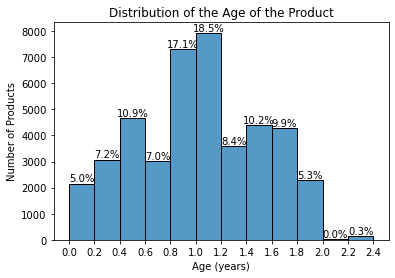

In [ ]:
sns.histplot(data=df, x="age", bins=[x/10 for x in range(25) if (x % 2 == 0)])
plt.xlabel("Age (years)")
plt.ylabel("Number of Products")
plt.xticks([x/10 for x in range(25) if (x % 2 == 0)])
plt.title("Distribution of the Age of the Product")
total = df["gtin"].count()

ax = plt.gca()

if total > 0:
    for p in ax.patches:
        if pd.notna(p.get_height()):
            ax.text(p.get_x() + p.get_width() / 2., p.get_height(),
                       '{:.1%}'.format(float(p.get_height() / total)),
                       fontsize=10, color='black', ha='center', va='bottom')
        else:
            ax.text(p.get_x() + p.get_width() / 2., 0, '0', fontsize=10,
                       color='black', ha='center', va='bottom')
plt.show()

### Distribution of Sales for different Categories

We want to check if sales distribution change across categories for different days of the week. Besides of this, the distribution by hour may change for each day. This could show us that the context is importante for the model

In [ ]:
# Plot day of the week sales distribution for different categories

def plot_categories_by_day(categories):
    _, ax = plt.subplots(2, 2, sharey=False, figsize=(15, 15))

    for i, category in zip([[0, 0], [0, 1], [1, 0], [1, 1]], categories):

        df_2 = df.loc[df.category_name.isin([category]), :]

        df_gr = df_2.groupby(["category_name", "day_name"])[["times"]].sum().reset_index()

        sns.barplot(data=df_gr, x="day_name", y="times", ax=ax[i[0], i[1]], order=["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"])
        ax[i[0], i[1]].set_title(category)
        ax[i[0], i[1]].set_xlabel("")
        ax[i[0], i[1]].set_ylabel("Productos Vendidos")

    plt.suptitle("Ventas por Día de la Semana")
    plt.show()
    
    return None

In [ ]:
# Plot hourly sales distribution for different days for a category

def plot_category_by_day(category, days):

    _, ax = plt.subplots(2, 2, sharey=False, figsize=(15, 15))

    for i, day in zip([[0, 0], [0, 1], [1, 0], [1, 1]], days):

        df_2 = df.loc[(df.category_name == category) &
                      (df.day_name == day), :]

        df_gr = df_2.groupby(["category_name", "day_name", "HOUR"])[["times"]].sum().reset_index()

        sns.barplot(data=df_gr, x="HOUR", y="times", ax=ax[i[0], i[1]])
        ax[i[0], i[1]].set_title(day)
        ax[i[0], i[1]].set_xlabel("")
        ax[i[0], i[1]].set_ylabel("Productos Vendidos")

    plt.suptitle(f"Ventas por Día de la Semana y Hora para {category}")
    plt.show()
    
    return None

In [ ]:
# Parameters
DAYS = {1: "Domingo", 2: "Lunes", 3: "Martes", 4: "Miércoles", 5: "Jueves", 6: "Viernes", 7: "Sábado"}

In [ ]:
QUERY = """
SELECT
category_name
, EXTRACT(DAYOFWEEK FROM timestamp) as DAY
, EXTRACT(HOUR FROM timestamp) as HOUR
, COUNT(*) as times
FROM `peya-food-and-groceries.user_fiorella_dirosario.order_sep2020_sep2021` o
LEFT JOIN `peya-food-and-groceries.user_fiorella_dirosario.order_details_sep2020_sep2021` od ON od.order_id = o.order_id
LEFT JOIN `peya-food-and-groceries.user_fiorella_dirosario.product_attributes_sep2020_sep2021` p ON p.gtin=od.gtin
WHERE od.has_gtin=1
GROUP BY 1,2,3
ORDER BY 1,2,3
"""

df = pandas_gbq.read_gbq(QUERY, project_id="peya-growth-and-onboarding")
df.to_csv("category_day_hour.csv", index=False)


Downloading: 100%|██████████| 22790/22790 [00:01<00:00, 14508.03rows/s]


In [ ]:
df = pd.read_csv("category_day_hour.csv")

df.loc[df.category_name.isin(['Cervezas Negras',
                              'Cervezas Rojas',
                              'Cervezas Rubias']), "category_name"] = "Cervezas"
                              
df["day_name"] = df.DAY.map(DAYS)


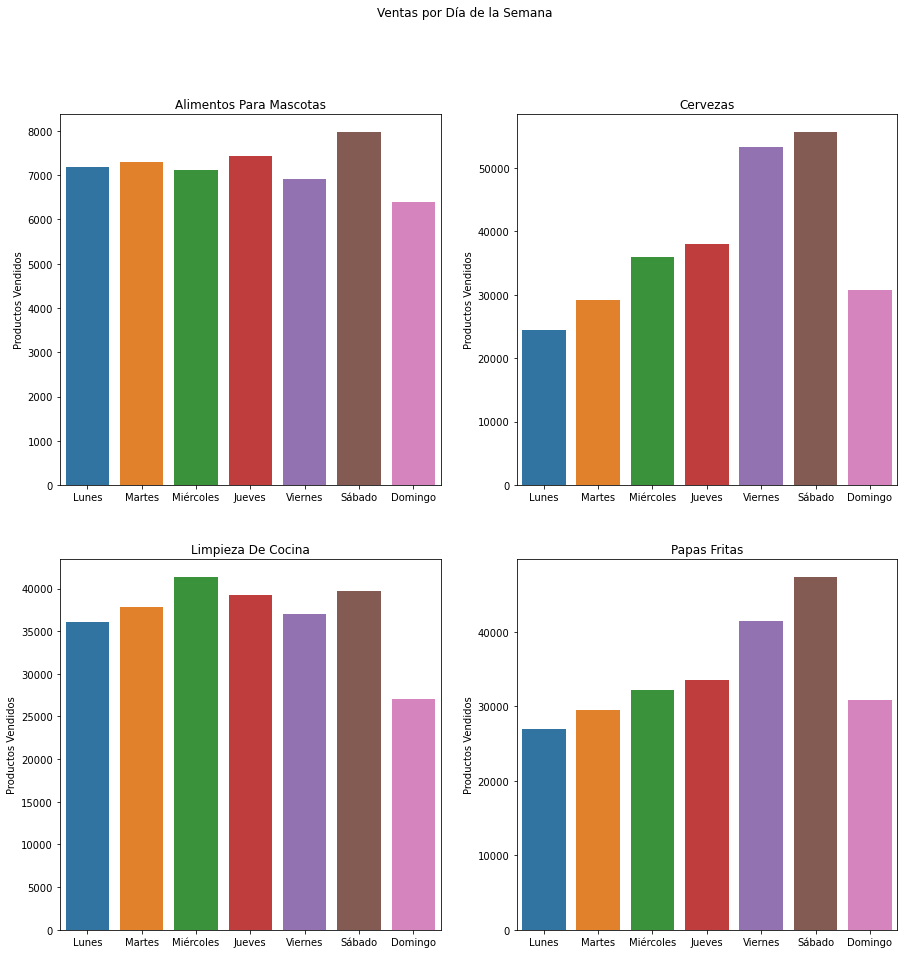

In [ ]:
plot_categories_by_day(['Alimentos Para Mascotas', 'Cervezas', 'Limpieza De Cocina', 'Papas Fritas'])

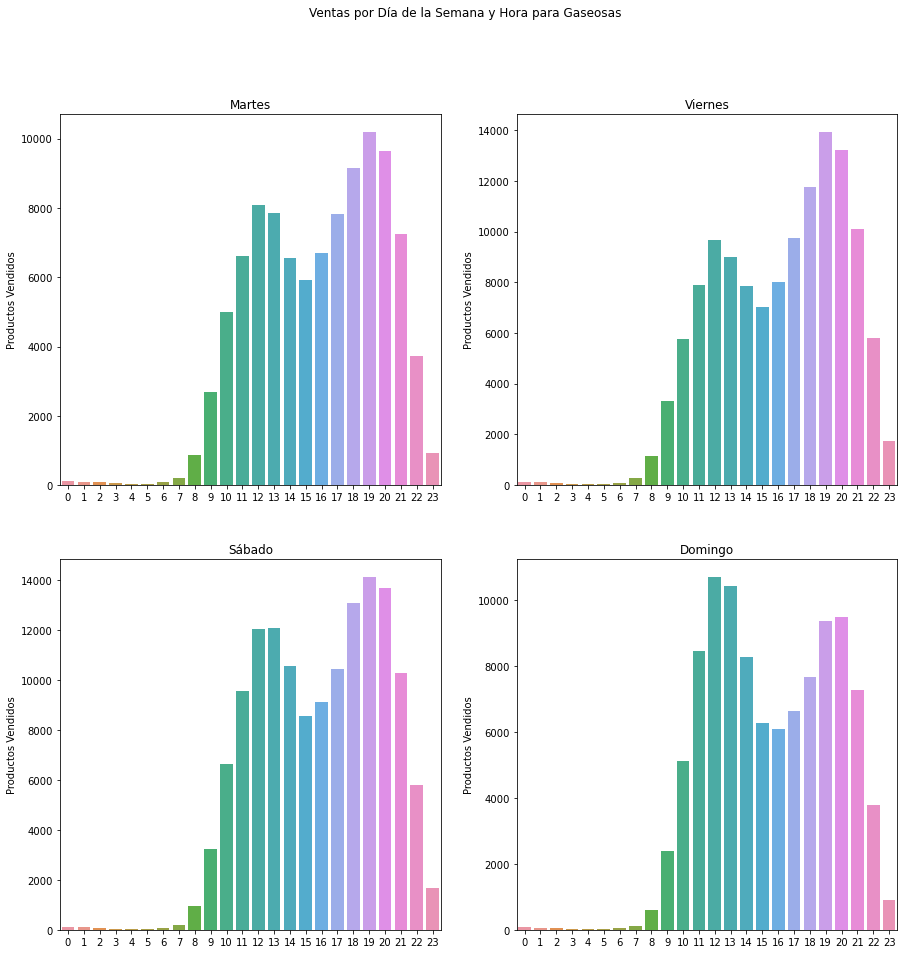

In [ ]:
plot_category_by_day('Gaseosas', ["Martes", "Viernes", "Sábado", "Domingo"])

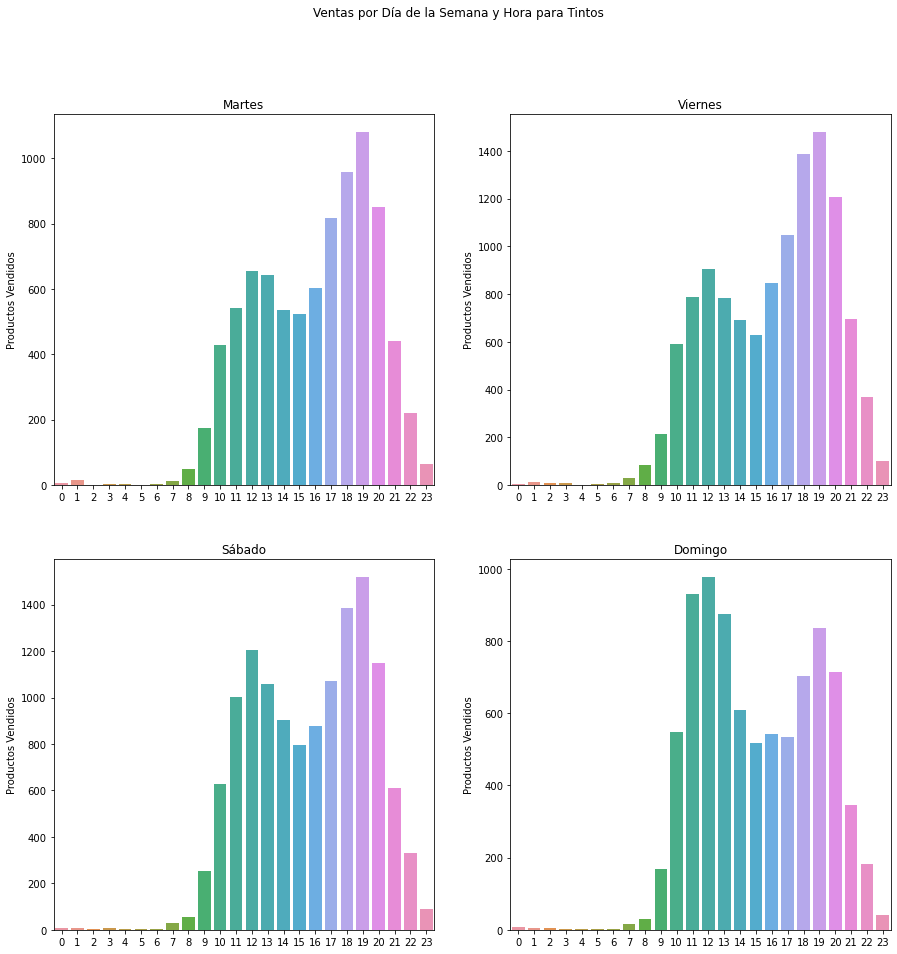

In [ ]:
plot_category_by_day('Tintos', ["Martes", "Viernes", "Sábado", "Domingo"])

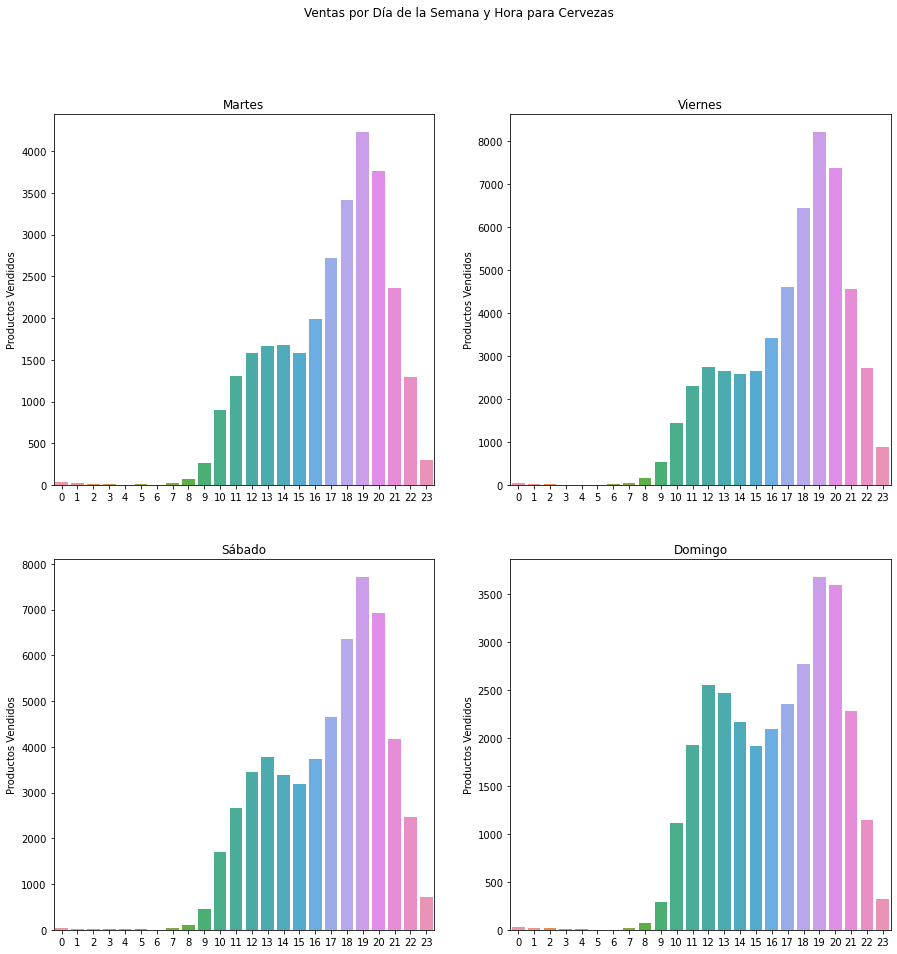

In [ ]:
plot_category_by_day('Cervezas', ["Martes", "Viernes", "Sábado", "Domingo"])

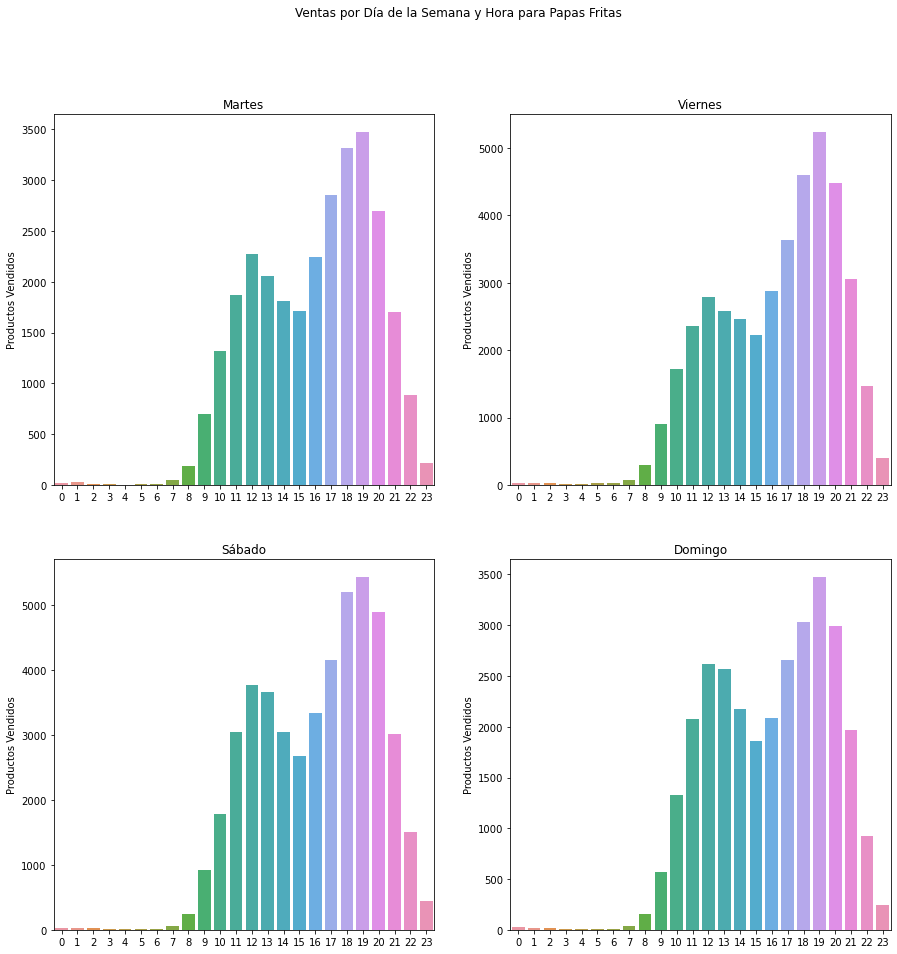

In [ ]:
plot_category_by_day('Papas Fritas', ["Martes", "Viernes", "Sábado", "Domingo"])

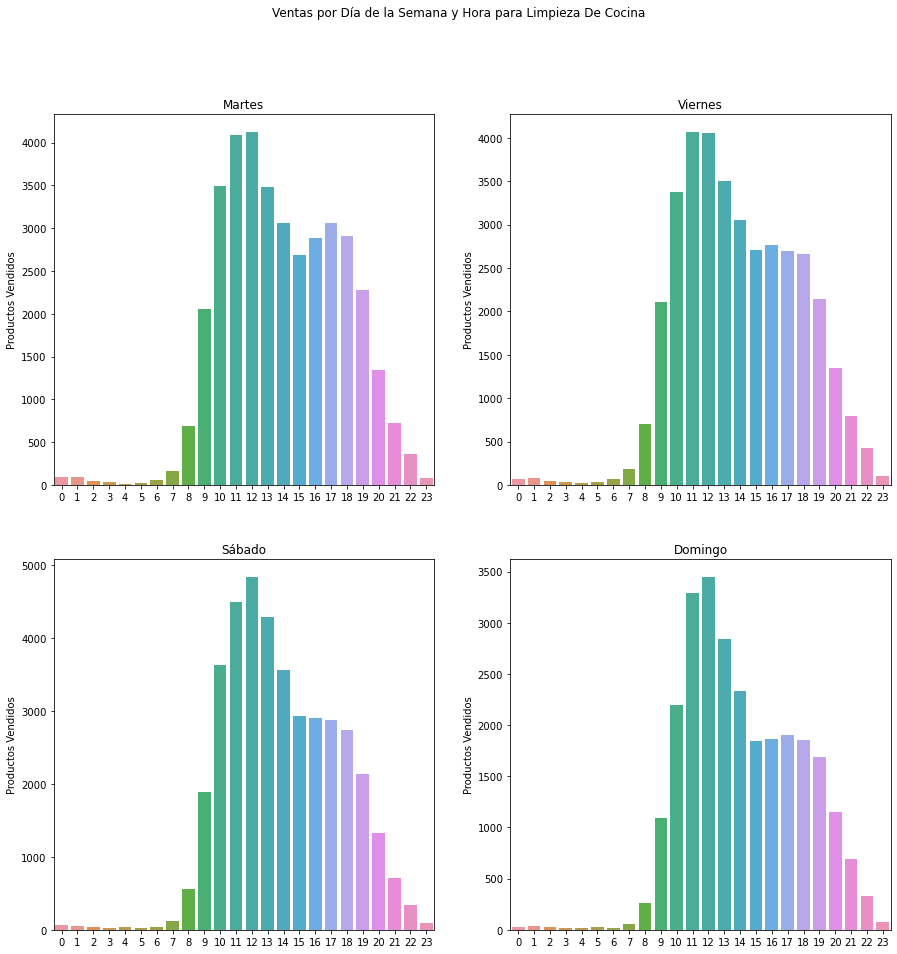

In [ ]:
plot_category_by_day('Limpieza De Cocina', ["Martes", "Viernes", "Sábado", "Domingo"])

### Orders Distribution by User and Most Popular Markets

In [ ]:
COUNTRY = "Argentina"

In [ ]:
QUERY = """
WITH most_frequent AS (
SELECT
o.user.id as user_id
, APPROX_TOP_COUNT(restaurant.name, 1)[OFFSET(0)].value as top_market

 FROM `peya-bi-tools-pro.il_core.fact_orders` o
 
 WHERE true
 AND registered_date BETWEEN "2020-09-01" AND "2021-09-30"
 AND business_type.business_type_id = 2
 AND o.order_status = "CONFIRMED"
GROUP BY 1
)

, min_date AS (
SELECT
o.user.id as user_id
, MIN(CASE WHEN business_type.business_type_id = 2 THEN o.registered_date END) as first_market_order_date
, MIN(CASE WHEN o.is_first_confirmed_order_user = 1 THEN o.registered_date END) as first_order_date 
 FROM `peya-bi-tools-pro.il_core.fact_orders` o
 
 WHERE true
 AND registered_date <= "2021-09-30"
 AND o.order_status = "CONFIRMED"
GROUP BY 1
)

SELECT

o.user.id as user_id
, u.country.country_name as country_name
, mf.top_market
, md.first_order_date
, DATE_TRUNC(md.first_order_date, MONTH) as first_order_month

, md.first_market_order_date
, DATE_TRUNC(md.first_market_order_date, MONTH) as first_market_order_month

, COUNT(DISTINCT o.order_id) as total_orders

, COUNT(DISTINCT DATE_TRUNC(o.registered_date, MONTH) ) as months_with_orders
, COUNT(DISTINCT CASE WHEN o.registered_date > md.first_market_order_date THEN o.order_id END) as total_orders_after_first_market
, COUNT(DISTINCT CASE WHEN o.registered_date > md.first_market_order_date THEN DATE_TRUNC(o.registered_date, MONTH) END) as months_with_orders_after_first_market

, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 THEN o.order_id END) as total_orders_markets
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND restaurant.name = mf.top_market THEN DATE_TRUNC(o.registered_date, MONTH) END) as months_most_freq
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND restaurant.name = mf.top_market THEN o.order_id END) as orders_most_freq
, SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND restaurant.name = mf.top_market THEN o.order_id END), COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 THEN o.order_id END)) AS pct_orders_most_freq
, SAFE_DIVIDE(COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND restaurant.name = mf.top_market THEN DATE_TRUNC(o.registered_date, MONTH) END), COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 THEN DATE_TRUNC(o.registered_date, MONTH) END)) as pct_months_most_freq


, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND DATE_TRUNC(o.registered_date, MONTH) = "2021-09-01" THEN o.order_id END) as market_orders_sept
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND DATE_TRUNC(o.registered_date, MONTH) = "2021-08-01" THEN o.order_id END) as market_orders_agosto
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND DATE_TRUNC(o.registered_date, MONTH) = "2021-07-01" THEN o.order_id END) as market_orders_julio
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND DATE_TRUNC(o.registered_date, MONTH) = "2021-06-01" THEN o.order_id END) as market_orders_junio
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND DATE_TRUNC(o.registered_date, MONTH) = "2021-05-01" THEN o.order_id END) as market_orders_mayo
, COUNT(DISTINCT CASE WHEN business_type.business_type_id = 2 AND DATE_TRUNC(o.registered_date, MONTH) = "2021-04-01" THEN o.order_id END) as market_orders_abril

, COUNT(DISTINCT CASE WHEN DATE_TRUNC(o.registered_date, MONTH) = "2021-09-01" THEN o.order_id END) as orders_sept
, COUNT(DISTINCT CASE WHEN DATE_TRUNC(o.registered_date, MONTH) = "2021-08-01" THEN o.order_id END) as orders_agosto
, COUNT(DISTINCT CASE WHEN DATE_TRUNC(o.registered_date, MONTH) = "2021-07-01" THEN o.order_id END) as orders_julio
, COUNT(DISTINCT CASE WHEN DATE_TRUNC(o.registered_date, MONTH) = "2021-06-01" THEN o.order_id END) as orders_junio
, COUNT(DISTINCT CASE WHEN DATE_TRUNC(o.registered_date, MONTH) = "2021-05-01" THEN o.order_id END) as orders_mayo
, COUNT(DISTINCT CASE WHEN DATE_TRUNC(o.registered_date, MONTH) = "2021-04-01" THEN o.order_id END) as orders_abril

FROM `peya-bi-tools-pro.il_core.fact_orders` o
INNER JOIN most_frequent mf ON mf.user_id = o.user.id
LEFT JOIN `peya-bi-tools-pro.il_core.dim_user` u ON u.user_id = o.user.id
LEFT JOIN min_date md ON md.user_id = o.user.id
WHERE o.registered_date BETWEEN "2020-09-01" AND "2021-10-04"
AND o.order_status = "CONFIRMED"
GROUP BY 1, 2, 3, 4, 5, 6, 7
"""

df = pandas_gbq.read_gbq(QUERY, project_id="peya-growth-and-onboarding", dialect='standard')

df.to_csv("data/orders_by_user.csv", index=False)

Downloading: 100%|██████████| 2528356/2528356 [19:28<00:00, 2163.36rows/s]


In [ ]:
df = pd.read_csv("data/orders_by_user.csv")
df = df[df.country_name == COUNTRY]
df.loc[(df.top_market.str.contains("PedidosYa Market")) &
       (~pd.isna(df.top_market)), "top_market"] = "PedidosYa Market"
       
df["has_1_order"] = df["total_orders_markets"] == 1
df["has_2_orders"] = df["total_orders_markets"] == 2
df["has_3_orders"] = df["total_orders_markets"] == 3
df["has_4_orders"] = df["total_orders_markets"] == 4
df["has_5_orders"] = df["total_orders_markets"] == 5
df["has_6_or_more_orders"] = df["total_orders_markets"] > 5

df["activo_agosto"] = df["market_orders_agosto"] > 0

df['first_market_order_month'] = pd.to_datetime(df['first_market_order_month'])
df['first_order_month'] = pd.to_datetime(df['first_order_month'])


df["is_acq"] = df['first_market_order_month'] == df['first_order_month']

df.loc[df['first_market_order_month'] < "2020-09-01", "first_market_order_month"] = "Before 2020-09"
df.loc[~(df['first_order_month'] >= "2020-09-01"), "first_order_month"] = "Before 2020-09"

df["quantity_orders"]  = df["total_orders_markets"]
df.loc[df["quantity_orders"] > 15, "quantity_orders"] = "+ 15"

In [ ]:
df.head()

,user_id,country_name,top_market,first_order_date,first_order_month,first_market_order_date,first_market_order_month,total_orders,months_with_orders,total_orders_after_first_market,...,orders_abril,has_1_order,has_2_orders,has_3_orders,has_4_orders,has_5_orders,has_6_or_more_orders,activo_agosto,is_acq,quantity_orders
0,24044437,Argentina,PedidosYa Market,2020-08-22,Before 2020-09,2021-08-18,2021-08-01 00:00:00,18,9,0,...,0,True,False,False,False,False,False,True,False,1
8,17788492,Argentina,DIA - Grand Bourg,2020-01-11,Before 2020-09,2021-09-26,2021-09-01 00:00:00,22,8,0,...,4,True,False,False,False,False,False,False,False,1
13,37794536,Argentina,PedidosYa Market,2021-08-24,2021-08-01 00:00:00,2021-08-24,2021-08-01 00:00:00,1,1,0,...,0,True,False,False,False,False,False,True,True,1
17,26626484,Argentina,PedidosYa Market,2021-02-16,2021-02-01 00:00:00,2021-09-23,2021-09-01 00:00:00,8,5,0,...,1,True,False,False,False,False,False,False,False,1
26,33929698,Argentina,Barbas - San Rafael,2021-04-27,2021-04-01 00:00:00,2021-04-30,2021-04-01 00:00:00,2,1,0,...,2,True,False,False,False,False,False,False,True,1


**Quantity of orders by user group by first order month in Markets**

In [ ]:
df.groupby(['first_market_order_month']).agg( users=("user_id", "nunique"),
                                              is_acq=("is_acq", "sum"),
                                              activo_agosto=("activo_agosto", "sum"),
                                              orders_agosto=("market_orders_agosto", "sum"),
                                              has_1_orders=("has_1_order", "mean"),
                                              has_2_orders=("has_2_orders", "mean"),
                                              has_3_orders=("has_3_orders", "mean"),
                                              has_4_orders=("has_4_orders", "mean"),
                                              has_5_orders=("has_5_orders", "mean"),
                                              has_6_or_more_orders=("has_6_or_more_orders", "mean")
                                              )

,users,is_acq,activo_agosto,orders_agosto,has_1_orders,has_2_orders,has_3_orders,has_4_orders,has_5_orders,has_6_or_more_orders
first_market_order_month,,,,,,,,,,
2020-09-01 00:00:00,52170,6174,7630,18891,0.412287,0.174046,0.095016,0.061357,0.041001,0.216293
2020-10-01 00:00:00,56934,8137,8526,21016,0.435557,0.168792,0.091439,0.057646,0.040240,0.206327
2020-11-01 00:00:00,47742,6189,7136,17824,0.450002,0.171777,0.092330,0.056680,0.039064,0.190147
2020-12-01 00:00:00,41950,5148,6574,15962,0.443814,0.184744,0.094422,0.055971,0.037950,0.183099
2021-01-01 00:00:00,47186,6162,7355,17935,0.455834,0.178464,0.093608,0.059255,0.037130,0.175709
2021-02-01 00:00:00,44948,6330,7252,16779,0.476239,0.174735,0.091506,0.056399,0.036776,0.164345
2021-03-01 00:00:00,56069,9761,9304,21164,0.489968,0.178744,0.088908,0.055949,0.036045,0.150386
2021-04-01 00:00:00,62207,12524,10422,23642,0.512595,0.178420,0.084814,0.053901,0.035366,0.134904
2021-05-01 00:00:00,80585,18119,13847,28682,0.543811,0.177415,0.085574,0.050332,0.031557,0.111311


**Active users in August by total orders of user**

In [ ]:

df.groupby(["quantity_orders"]).agg(users=("user_id", "nunique"),
                                    activo_agosto=("activo_agosto", "sum"),
                                    orders_agosto=("market_orders_agosto", "sum")
                                    )

,users,activo_agosto,orders_agosto
quantity_orders,,,
1,564970,78012,78012
2,170940,32379,38836
3,82683,21236,27275
4,50125,15683,21340
5,33400,12348,17981
6,24069,10143,15891
7,18404,8625,14368
8,14621,7270,12883
9,11641,6180,11548


**Users with more than 5 Orders**

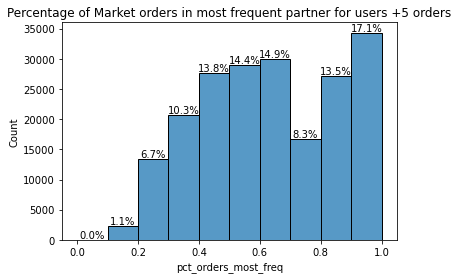

In [ ]:
df_more_5 = df[df.total_orders_markets >= 5]
total = df_more_5.shape[0]

ax = plt.gca()

sns.histplot(data=df_more_5, x="pct_orders_most_freq",
             bins=[x / 10 for x in range(0, 11)], ax=ax)
             


for p in ax.patches:
      ax.text(p.get_x() + p.get_width()/2., p.get_height(),
                  '{:.1%}'.format(float(p.get_height()/total)),
              fontsize=10, color='black', ha='center', va='bottom')

ax.set_title("Percentage of Market orders in most frequent partner for users +5 orders")

plt.show()

In [ ]:
df_gr = df_more_5.groupby(["top_market"])[["user_id"]].nunique().sort_values(by="user_id", ascending=False)

print(df_gr)

                                               user_id
top_market                                            
PedidosYa Market                                 94980
Carrefour - Market La Plata                       1533
Hiper Libertad Mendoza                            1117
La Anónima - Neuquén Centro                       1117
Supermercado Dar - Rioja                          1107
...                                                ...
Punto Copec - Iquique                                1
Punto Copec - Irarrazaval                            1
Longi Alimentos                                      1
Punto Copec - Lomas De Sa                            1
GoFriz Congelados Grido - 4938 - Tucuman XXXI        1

[2363 rows x 1 columns]


### Plotting a word cloud for most popular products in Markets

In [ ]:
# Function for Word Cloud Colors
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")

In [ ]:
QUERY = """
WITH product_name AS (
SELECT
gtin
, MAX(product_name) as name
FROM `peya-food-and-groceries.user_fiorella_dirosario.order_details_sep2020_sep2021`
WHERE has_gtin = 1 AND product_name IS NOT NULL
GROUP BY 1
)
SELECT
pn.name
, COUNT(*) as count
FROM `peya-food-and-groceries.user_fiorella_dirosario.order_details_sep2020_sep2021` od
LEFT JOIN product_name pn ON pn.gtin = od.gtin
WHERE has_gtin = 1
GROUP BY 1
"""

file = pandas_gbq.read_gbq(QUERY, project_id="peya-growth-and-onboarding")
file.to_csv("wordcloud.csv", index=False)
file = pd.read_csv(r"C:\Users\patricio.woodley\Documents\GitHub\repo-data-analytics-growth\dataton\wordcloud.csv")

print(file.head())

Downloading: 100%|██████████| 32451/32451 [00:03<00:00, 9575.61rows/s]

                                           name  count
0                  Mayonesa Natura Sachet 125C.   1306
1           Sandwich Miga clasico jamon y queso  24136
2  Agua saborizada con gas H2Oh limóneto 1.5 l.   2480
3                          Sémola Vitina 500 G.   2901
4           Leche Descremada DIA Larga Vida 1 L  22079


In [ ]:
file = pd.read_csv("wordcloud.csv")

# Preprocessing
file = file.dropna()
file["count"] = file["count"].astype("int")
file = file.sort_values(by="count", ascending=False)
file = file.set_index(file["name"], drop=True)
del file["name"]

file_dict = file["count"].to_dict()

print(file_dict)

{'Gaseosa sabor original coca cola 2.25 L': 129215, 'Azúcar Ledesma clásica 1 kg': 68330, 'Queso Cremoso Tregar Unidad Aprox. 450Grs.': 68167, 'Leche parcialmente descremada La Serenísima 1% 1 L': 63955, 'Papa Blanca X 1Kg': 50749, 'Gaseosa Coca Cola 1.5 L.': 47978, 'Pan Bimbo Artesano 500 g': 47656, 'Gaseosa Coca-Cola Sin Azúcar 2,25 Lt': 47371, 'Queso rallado Tregar 120 g': 47276, 'Jamón cocido feteado La Comarca 200 g.': 44116, 'Banana X 1Kg': 43329, 'Leche larga vida entera Tregar 1 L': 43170, 'Leche larga vida descremada Tregar 1 L': 43014, 'Agua mineralizada sin gas Cellier Favaloro 2 l.': 42692, 'Rollo De Cocina Elegante 3 X 50 Paños': 42295, 'Cebolla X 1Kg': 41988, 'Gaseosa Coca Cola Sin Az��ares 1.5 L.': 40356, 'Manteca Multivitaminas La Serenísima 200gr': 37745, 'Galletitas chocolate chocolinas 250 g': 37082, 'Zanahoria X 1Kg': 35848, 'Tomate Redondo X 1Kg': 35732, 'Papel Higiénico Hoja Simple Elegante 4 X 30 M.': 35481, 'Azúcar Chango Tipo A 1 Kg.': 34758, 'Agua de mesa Kin 

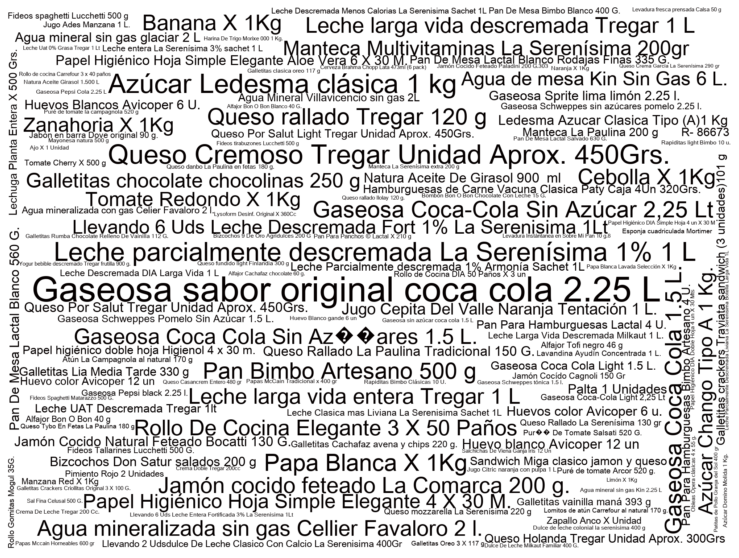

In [ ]:
wordcloud = WordCloud(font_path=r"C:\Users\patricio.woodley\Documents\GitHub\repo-data-analytics-growth\dataton\arial-unicode-ms.ttf",
                      background_color="white", width=2000, height=1500, max_words=150).generate_from_frequencies(file_dict)

wordcloud.recolor(color_func=black_color_func)
plt.figure(figsize=[15, 10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Models

### Baseline

In [ ]:
input_path = "models/base_line_model/index_model/1"
model = tf.saved_model.load(input_path)

Recommend products to out of bag users (cold start problem)

In [ ]:
score, products = model(tf.constant(["oob"]))
products.numpy()

array([[b'7791337002012', b'7790742172006', b'7791337000926',
        b'7791813421580', b'7790742333605', b'7790895010088',
        b'7791813421917', b'7790742172105', b'7796989075803',
        b'7791337001978']], dtype=object)

In [ ]:
score, products = model(tf.constant([""]))
products.numpy()

array([[b'7791337002012', b'7790742172006', b'7791337000926',
        b'7791813421580', b'7790742333605', b'7790895010088',
        b'7791813421917', b'7790742172105', b'7796989075803',
        b'7791337001978']], dtype=object)

Recommend products to existent users

In [ ]:
score, products = model(tf.constant(["4655437"]))
products.numpy()

array([[b'8480017203809', b'77912268', b'7791813050520',
        b'8480017300768', b'7798130951776', b'8480017518644',
        b'8480017053480', b'8480017154057', b'8480017188274',
        b'8480017183507']], dtype=object)

In [ ]:
score, products = model(tf.constant(["35417324"]))
products.numpy()

array([[b'7793046008019', b'7798061000376', b'7796490000028',
        b'7790580111533', b'7791058000731', b'7790828102095',
        b'7790022000357', b'7790383000102', b'7790070508348',
        b'7790062000584']], dtype=object)

### Two-tower model

The most simple recommendation system model is a matrix factorization, so we build a FM using a Tensorflow to learn the user and product embedding or latent vector. The idea is get a numeric representation of users and product and then get the dot product to get the implicit preferences.
[Reference](https://www.tensorflow.org/recommenders/examples/basic_retrieval)

In [ ]:
class MarketsModel(tfrs.Model):

    def __init__(
            self,
            user_model: tf.keras.Model,
            product_model: tf.keras.Model,
            task: tf.keras.layers.Layer
    ):
        super().__init__()
        self.user_model = user_model
        self.product_model = product_model
        self.task: tf.keras.layers.Layer = task

    def compute_loss(
            self,
            features: Dict[Text, tf.Tensor],
            training=False
    ) -> tf.Tensor:
        user_embeddings = self.user_model(features["user_id"])
        positive_product_embeddings = self.product_model(features["product_id"])
        compute_metrics = False if training else True
        return self.task(
            user_embeddings,
            positive_product_embeddings,
            compute_metrics=compute_metrics
        )

In [ ]:
embedding_dimension = 32

user_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=tf.convert_to_tensor(user_ids),
        mask_token=None
    ),
    tf.keras.layers.Embedding(len(user_ids) + 1, embedding_dimension)
])

product_model = tf.keras.Sequential([
    tf.keras.layers.StringLookup(
        vocabulary=tf.convert_to_tensor(product_ids)
        , mask_token=None
    ),
    tf.keras.layers.Embedding(len(product_ids) + 1, embedding_dimension)
])

metrics = tfrs.metrics.FactorizedTopK(
    candidates=products_ds.batch(128).map(product_model)
)

task = tfrs.tasks.Retrieval(
    metrics=metrics
)

In [ ]:
model = MarketsModel(user_model, product_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

In [ ]:
cached_train = interactions_train_ds.batch(8192).cache()
history = model.fit(cached_train, epochs=5)

Epoch 1/5
1557/1557 [==============================] - 47s 29ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 69825.9993 - regularization_loss: 0.0000e+00 - total_loss: 69825.9993
Epoch 2/5
1557/1557 [==============================] - 23s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 65864.3539 - regularization_loss: 0.0000e+00 - total_loss: 65864.3539
Epoch 3/5
1557/1557 [==============================] - 23s 15ms/step - factorized_top_k/top_1_categorical_accuracy: 0.

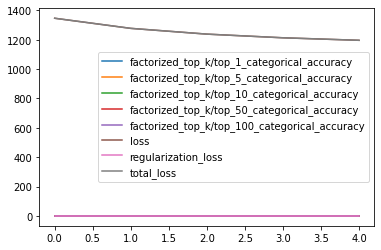

In [ ]:
pd.DataFrame(history.history).plot()

### Two-tower model with context

In [ ]:
class QueryModel(tf.keras.Model):

    def __init__(self, user_ids: list):
        super().__init__()

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=user_ids),
            tf.keras.layers.Embedding(len(user_ids) + 1, 32)
        ])
        self.dow_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=[f"{k}" for k in range(7)]),
            tf.keras.layers.Embedding(8, 4)
        ])
        self.hod_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=[f"{k}" for k in range(24)]),
            tf.keras.layers.Embedding(25, 4)
        ])

    def call(self, inputs: Dict[Text, tf.Tensor]):
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.dow_embedding(inputs["dow"]),
            self.hod_embedding(inputs["hod"]),
        ], axis=1)

In [ ]:
class CandidateModel(tf.keras.Model):

    def __init__(
            self,
            gtin_ids: list,
            category_ids: list,
            brand_ids: list,
            age_mean: float = None,
            age_var: float = None
    ):
        super().__init__()

        #product_name_tokenizer = tf.keras.layers.TextVectorization()
        #product_name_tokenizer.adapt(products_ds.map(lambda x: x["product_name"]))
        #self.title_text_embedding = tf.keras.Sequential([
        #  product_name_tokenizer,
        #  tf.keras.layers.Embedding(input_dim=10_000, output_dim=32, mask_zero=True),
        #  tf.keras.layers.GlobalAveragePooling1D(),
        #])

        self.gtin_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=gtin_ids),
            tf.keras.layers.Embedding(len(gtin_ids) + 1, 32)
        ])

        self.category_id_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=category_ids, mask_token=None),
            tf.keras.layers.Embedding(len(category_ids) + 1, 6)
        ])

        self.brand_id_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=brand_ids, mask_token=None),
            tf.keras.layers.Embedding(len(brand_ids) + 1, 10)
        ])

        #self.normalized_age = tf.keras.layers.Normalization(mean=age_mean, variance=age_var)

    def call(self, inputs: Dict[Text, tf.Tensor]):
        return tf.concat([
            self.gtin_embedding(inputs["gtin"]),
            self.category_id_embedding(inputs["category_id"]),
            self.brand_id_embedding(inputs["brand_id"]),
            #tf.reshape(self.normalized_age(inputs["age"]), (-1, 1)),
        ], axis=1)

In [ ]:
class MarketsModel(tfrs.models.Model):

    def __init__(
            self,
            query_model: tf.keras.Model,
            candidate_model: tf.keras.Model,
    ):
        super().__init__()
        self.query_model = tf.keras.Sequential([
            query_model,
            tf.keras.layers.Dense(32)
        ])
        self.candidate_model = tf.keras.Sequential([
            candidate_model,
            tf.keras.layers.Dense(32)
        ])
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=products_ds.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(
            self,
            features: Dict[Text, tf.Tensor],
            training=False,
    ):
        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            "dow": features["dow"],
            "hod": features["hod"],
        })
        candidate_embeddings = self.candidate_model({
            "gtin": tf.strings.as_string(features["gtin"]),
            "category_id": features["category_id"],
            "brand_id": features["brand_id"],
            #"age": features["age"],
        })
        compute_metrics = False if training else True

        return self.task(query_embeddings, candidate_embeddings, compute_metrics=compute_metrics)

In [ ]:
query_model = QueryModel(user_ids)
product_model = CandidateModel(gtin_ids, category_ids, brand_ids)

In [ ]:
for row in products_ds.batch(2).take(1):
    print(row)
    print(f"Computed representations: {product_model(row)[0, :].shape}")

{'gtin': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'07613035494800', b'07792900092706'], dtype=object)>, 'category_id': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([176, 117], dtype=int32)>, 'brand_id': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([2736, 8735], dtype=int32)>}
Computed representations: (48,)


In [ ]:
for row in users_ds.batch(2).take(1):
    print(row)
    print(f"Computed representations: {query_model(row)[0, :].shape}")

{'user_id': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([19431540,  6361976], dtype=int32)>, 'dow': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 3], dtype=int32)>, 'hod': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([11, 17], dtype=int32)>}
Computed representations: (40,)


In [ ]:
model = MarketsModel(query_model, product_model)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

Consider rewriting this model with the Functional API.


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

history = model.fit(interactions_train_ds, epochs=2, callbacks=[callback])

Epoch 1/2
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2088/2088 [==============================] - 287s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 67249.5691 - regularization_loss: 0.0000e+00 - total_loss: 67249.5691
Epoch 2/2
2088/2088 [==============================] - 38s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categori

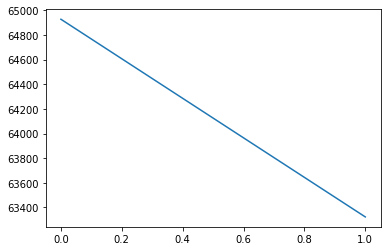

In [ ]:
pd.DataFrame(history.history)["loss"].plot()

### Two-tower model with context (simple)

In this experiment we build a two tower model with 2 inputs, query and candidates. In this version we only add mode context in query tower using user_id, day of week and hour of the day.


![](https://1.bp.blogspot.com/-ww8cKT3nIb8/X2pdWAWWNmI/AAAAAAAADl8/pkeFRxizkXYbDGbOcaAnZkorjEuqtrabgCLcBGAsYHQ/s0/TF%2BRecommenders%2B06.gif)

In [ ]:
class QueryModel(tf.keras.Model):

    def __init__(self, user_ids: list):
        super().__init__()

        self.user_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=user_ids),
            tf.keras.layers.Embedding(len(user_ids) + 1, 32)
        ])
        self.dow_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=[f"{k}" for k in range(7)]),
            tf.keras.layers.Embedding(8, 4)
        ])
        self.hod_embedding = tf.keras.Sequential([
            tf.keras.layers.IntegerLookup(vocabulary=[f"{k}" for k in range(24)]),
            tf.keras.layers.Embedding(25, 4)
        ])

    def call(self, inputs: Dict[Text, tf.Tensor]):
        return tf.concat([
            self.user_embedding(inputs["user_id"]),
            self.dow_embedding(inputs["dow"]),
            self.hod_embedding(inputs["hod"]),
        ], axis=1)

In [ ]:
class CandidateModel(tf.keras.Model):

    def __init__(self, gtin_ids):
        super().__init__()

        self.gtin_embedding = tf.keras.Sequential([
            tf.keras.layers.StringLookup(vocabulary=gtin_ids),
            tf.keras.layers.Embedding(len(gtin_ids) + 1, 32)
        ])

    def call(self, inputs: Dict[Text, tf.Tensor]):
        return self.gtin_embedding(inputs["gtin"])

In [ ]:
class MarketsModel(tfrs.models.Model):

    def __init__(
            self,
            query_model: tf.keras.Model,
            candidate_model: tf.keras.Model,
    ):
        super().__init__()
        self.query_model = tf.keras.Sequential([
            query_model,
            tf.keras.layers.Dense(32)
        ])
        self.candidate_model = tf.keras.Sequential([
            candidate_model,
            tf.keras.layers.Dense(32)
        ])
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
                candidates=products_ds.batch(128).map(self.candidate_model),
            ),
        )

    def compute_loss(
            self,
            features: Dict[Text, tf.Tensor],
            training=False,
    ):
        query_embeddings = self.query_model({
            "user_id": features["user_id"],
            "dow": features["dow"],
            "hod": features["hod"],
        })
        candidate_embeddings = self.candidate_model({"gtin": tf.strings.as_string(features["gtin"])})
        compute_metrics = False if training else True

        return self.task(query_embeddings, candidate_embeddings, compute_metrics=compute_metrics)

In [ ]:
query_model = QueryModel(user_ids)
product_model = CandidateModel(gtin_ids)

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2378: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
/usr/local/lib/python3.7/dist-packages/keras/layers/preprocessing/index_lookup.py:465: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.oov_token in tokens:


In [ ]:
for row in products_ds.batch(2).take(1):
    print(row)
    print(f"Computed representations: {product_model(row)[0, :].shape}")

{'gtin': <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'07790010669078', b'07891010245573'], dtype=object)>}
Computed representations: (32,)


In [ ]:
for row in users_ds.batch(2).take(1):
    print(row)
    print(f"Computed representations: {query_model(row)[0, :].shape}")

{'user_id': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([4021467, 7270565], dtype=int32)>, 'dow': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 2], dtype=int32)>, 'hod': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([14, 20], dtype=int32)>}
Computed representations: (40,)


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=1000,
    decay_rate=0.9)

model = MarketsModel(query_model, product_model)
model.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule))

Consider rewriting this model with the Functional API.


In [ ]:
history = model.fit(
    interactions_train_ds,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)],
    epochs=50)

Epoch 1/50
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
2088/2088 [==============================] - 178s 20ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 68607.0465 - regularization_loss: 0.0000e+00 - total_loss: 68607.0465
Epoch 2/50
2088/2088 [==============================] - 42s 20ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_catego

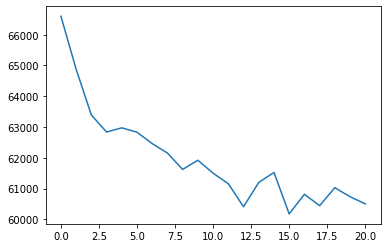

In [ ]:
pd.DataFrame(history.history)["loss"].plot()

## Evaluation

In order to calculate the evaluation metrics quickly, we are using Bigquery.

In [ ]:
def get_metrics(table_id, k, project_id, minimum_orders=2, maximum_orders=1000, is_most_popular=False, is_context_model=False):
    
    if is_most_popular:
        comm1 = "--"
        comm2 = ""
    else:
        comm1 = ""
        comm2 = "--"
        
    if is_context_model:
        comm3 = "--"
        comm4 = ""
    else:
        comm3 = ""
        comm4 = "--"   

    query = f"""
    
    DECLARE minimum_products INT64;
    DECLARE minimum_orders INT64;
    DECLARE maximum_orders INT64;
    DECLARE k INT64;

    SET minimum_products = 5;
    SET minimum_orders = {minimum_orders};
    SET maximum_orders = {maximum_orders};
    SET k = {k};

    WITH products_by_user AS (
        SELECT
            uo.user_id
          , COUNT(DISTINCT gtin) as cant_products
          , COUNT(DISTINCT uo.order_id) as cant_orders
          , MAX(uo.order_id) as last_order_id
        FROM 
          `peya-food-and-groceries.user_fiorella_dirosario.order_sep2020_sep2021` as uo
        JOIN 
          `peya-food-and-groceries.user_fiorella_dirosario.order_details_sep2020_sep2021` as od
        ON 
          uo.order_id = od.order_id  
        WHERE 
          uo.user_id IS NOT NULL
          AND od.gtin IS NOT NULL
          AND od.has_gtin = 1
        GROUP BY 1
    )

    , test AS (
    SELECT DISTINCT
        CAST(uo.user_id AS STRING) AS user_id
      , CAST(od.gtin AS STRING) AS product_id
      --, uo.order_id
      --, uo.timestamp
    FROM 
      `peya-food-and-groceries.user_fiorella_dirosario.order_sep2020_sep2021` as uo
    JOIN 
      `peya-food-and-groceries.user_fiorella_dirosario.order_details_sep2020_sep2021` as od
    ON
      uo.order_id = od.order_id
    LEFT JOIN 
      products_by_user pbu 
    ON 
      pbu.user_id = uo.user_id
    WHERE 
      uo.user_id IS NOT NULL
      AND od.gtin IS NOT NULL
      AND od.has_gtin = 1
      AND cant_products >= minimum_products
      AND cant_orders >= minimum_orders
      AND cant_orders <= maximum_orders
      AND uo.order_id = pbu.last_order_id 
    )

    , predictions AS 

    (
        {comm3}SELECT * FROM `{table_id}` WHERE rank < k
        {comm4}SELECT CAST(user_id AS STRING) as user_id, gtin as product_id, rank FROM `{table_id}` WHERE rank < k
    )


    , cross_join AS (
    SELECT
    t.user_id
    , p.rank
    , p.product_id as product_predicted
    , t.product_id  as product_test
    , CASE WHEN t.product_id = p.product_id THEN 1 ELSE 0 END as hit_rate
    , CASE WHEN t.product_id = p.product_id THEN 1 / (p.rank + 1) ELSE 0 END as map_at_k
    FROM test t 
    {comm1}LEFT JOIN predictions p ON p.user_id = t.user_id
    {comm2}CROSS JOIN predictions p
    WHERE p.rank < k
    ORDER BY 1, 4, 2
    )

    , metric_by_user AS (
    SELECT
    user_id
    , SUM(hit_rate) as hit_rate
    , SUM(map_at_k) as map_at_k
    FROM cross_join 
    GROUP BY 1

    )

    SELECT
    COUNT(DISTINCT user_id) as users
    , AVG(hit_rate) as hit
    , AVG(map_at_k) as precision
    FROM metric_by_user
    
    """
    
    df = pandas_gbq.read_gbq(query, project_id=project_id, dialect='standard')

    return df


### Random Predictions

In [ ]:
get_metrics(table_id='peya-growth-and-onboarding.user_patricio_woodley.user_recommendation_random', k=5, project_id='peya-growth-and-onboarding', is_most_popular=False)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.55rows/s]


,hit,precision
0,0.000875,0.000395


In [ ]:
get_metrics(table_id='peya-growth-and-onboarding.user_patricio_woodley.user_recommendation_random', k=10, project_id='peya-growth-and-onboarding', is_most_popular=False)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.44rows/s]


,hit,precision
0,0.001854,0.000521


### k-popular Products

In [ ]:
get_metrics(table_id='peya-food-and-groceries.user_fiorella_dirosario.popular_products_train', k=5, project_id='peya-growth-and-onboarding', is_most_popular=True)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.92rows/s]


,hit,precision
0,0.083081,0.045322


In [ ]:
get_metrics(table_id='peya-food-and-groceries.user_fiorella_dirosario.popular_products_train', k=10, project_id='peya-growth-and-onboarding', is_most_popular=True)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.83rows/s]


,hit,precision
0,0.136766,0.052362


In [ ]:
get_metrics(table_id='peya-food-and-groceries.user_fiorella_dirosario.popular_products_train', k=50, project_id='peya-growth-and-onboarding', is_most_popular=True)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.52rows/s]


,hit,precision
0,0.465319,0.066248


In [ ]:
get_metrics(table_id='peya-food-and-groceries.user_fiorella_dirosario.popular_products_train', k=100, project_id='peya-growth-and-onboarding', is_most_popular=True)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.44rows/s]


,hit,precision
0,0.724531,0.069911


In [ ]:
get_metrics(table_id='peya-food-and-groceries.user_fiorella_dirosario.popular_products_train', minimum_orders=2, maximum_orders=5, k=10, project_id='peya-growth-and-onboarding', is_most_popular=True)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.67rows/s]


,users,hit,precision
0,228927,0.128325,0.051607


In [ ]:
get_metrics(table_id='peya-food-and-groceries.user_fiorella_dirosario.popular_products_train', minimum_orders=6, maximum_orders=10, k=10, project_id='peya-growth-and-onboarding', is_most_popular=True)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.81rows/s]


,users,hit,precision
0,60176,0.142249,0.052337


In [ ]:
get_metrics(table_id='peya-food-and-groceries.user_fiorella_dirosario.popular_products_train', minimum_orders=11, maximum_orders=10000, k=10, project_id='peya-growth-and-onboarding', is_most_popular=True)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.64rows/s]


,users,hit,precision
0,67478,0.160512,0.054946


### Baseline Model

In [ ]:
get_metrics(table_id='peya-growth-and-onboarding.user_patricio_woodley.user_recommendation_baseline', k=5, project_id='peya-growth-and-onboarding', is_most_popular=False)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.47rows/s]


,hit,precision
0,0.11113,0.058682


In [ ]:
get_metrics(table_id='peya-growth-and-onboarding.user_patricio_woodley.user_recommendation_baseline', k=10, project_id='peya-growth-and-onboarding', is_most_popular=False)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.38rows/s]


,hit,precision
0,0.174757,0.067039


In [ ]:
get_metrics(table_id='peya-growth-and-onboarding.user_patricio_woodley.user_recommendation_baseline', k=10, minimum_orders=2, maximum_orders=5, project_id='peya-growth-and-onboarding', is_most_popular=False)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.91rows/s]


,users,hit,precision
0,228927,0.189768,0.075524


In [ ]:
get_metrics(table_id='peya-growth-and-onboarding.user_patricio_woodley.user_recommendation_baseline', k=10, minimum_orders=6, maximum_orders=10, project_id='peya-growth-and-onboarding', is_most_popular=False)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.84rows/s]


,users,hit,precision
0,60176,0.168223,0.059901


In [ ]:
get_metrics(table_id='peya-growth-and-onboarding.user_patricio_woodley.user_recommendation_baseline', k=10, minimum_orders=11, maximum_orders=10000, project_id='peya-growth-and-onboarding', is_most_popular=False)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.61rows/s]


,users,hit,precision
0,67478,0.129657,0.044617


In [ ]:
get_metrics(table_id='peya-growth-and-onboarding.user_patricio_woodley.user_recommendation_baseline', k=10, minimum_orders=2, maximum_orders=5, project_id='peya-growth-and-onboarding', is_most_popular=False)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.91rows/s]


,users,hit,precision
0,228927,0.189768,0.075524


In [ ]:
get_metrics(table_id='peya-growth-and-onboarding.user_patricio_woodley.user_recommendation_baseline', k=10, minimum_orders=6, maximum_orders=10, project_id='peya-growth-and-onboarding', is_most_popular=False)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  1.84rows/s]


,users,hit,precision
0,60176,0.168223,0.059901


In [ ]:
get_metrics(table_id='peya-growth-and-onboarding.user_patricio_woodley.user_recommendation_baseline', k=10, minimum_orders=11, maximum_orders=10000, project_id='peya-growth-and-onboarding', is_most_popular=False)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.61rows/s]


,users,hit,precision
0,67478,0.129657,0.044617


### Context Model

In [ ]:
get_metrics(table_id="peya-food-and-groceries.user_fiorella_dirosario.recommendation_context_model", k=5, project_id='peya-growth-and-onboarding', is_context_model=True)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.46rows/s]


,hit,precision
0,0.038249,0.019447


In [ ]:
get_metrics(table_id="peya-food-and-groceries.user_fiorella_dirosario.recommendation_context_model", k=10, project_id='peya-growth-and-onboarding', is_context_model=True)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.09rows/s]


,hit,precision
0,0.064157,0.022833


In [ ]:
get_metrics(table_id="peya-food-and-groceries.user_fiorella_dirosario.recommendation_context_model", minimum_orders=2, maximum_orders=5, k=10, project_id='peya-growth-and-onboarding', is_context_model=True)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.84rows/s]


,users,hit,precision
0,228927,0.059412,0.021563


In [ ]:
get_metrics(table_id="peya-food-and-groceries.user_fiorella_dirosario.recommendation_context_model", minimum_orders=6, maximum_orders=10, k=10, project_id='peya-growth-and-onboarding', is_context_model=True)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.86rows/s]


,users,hit,precision
0,60176,0.069114,0.023902


In [ ]:
get_metrics(table_id="peya-food-and-groceries.user_fiorella_dirosario.recommendation_context_model", minimum_orders=11, maximum_orders=10000, k=10, project_id='peya-growth-and-onboarding', is_context_model=True)

Downloading: 100%|██████████| 1/1 [00:00<00:00,  2.83rows/s]


,users,hit,precision
0,67478,0.075832,0.026187


## Inference

### Brute force

Brute force compute the product between user and all product.

In [ ]:
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(
    tf.data.Dataset.zip((products_ds.batch(100), products_ds.batch(100).map(model.product_model)))
)

In [ ]:
# Get recommendations.
score, titles = index(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :20]}")

Recommendations for user 42: [b'7790895009679' b'7790895064135' b'7792335000314' b'07790199603368'
 b'8480017186003' b'08480017183514' b'7792335000345' b'2970200000118'
 b'2970200000019' b'7798162981000']


In [ ]:
% timeit _, titles = index(tf.constant(["42"]))

1000 loops, best of 5: 1.41 ms per loop


### ScaNN

Scann is an efficient Nearest neighbor approximation to retrieve the top k product.

In [ ]:
scann = tfrs.layers.factorized_top_k.ScaNN(model.user_model)
scann.index_from_dataset(
    tf.data.Dataset.zip((products_ds.batch(100), products_ds.batch(100).map(model.product_model)))
)

In [ ]:
score, titles = scann(tf.constant(["42"]))
print(f"Recommendations for user 42: {titles[0, :20]}")

Recommendations for user 42: [b'08480017183514' b'7790895009679' b'8480017186003' b'00648260560126'
 b'08480017005045' b'08480017192912' b'07798164190592' b'07798143350566'
 b'08480017123923' b'08480017218865']


In [ ]:
% timeit score, titles = scann(tf.constant(["42"]))

1000 loops, best of 5: 1.95 ms per loop


In [ ]:
scann = tfrs.layers.factorized_top_k.ScaNN(model.query_model)
scann.index_from_dataset(
    tf.data.Dataset.zip(
        (products_ds.map(lambda x: x["gtin"]).batch(100), products_ds.batch(100).map(model.candidate_model)))
)

Consider rewriting this model with the Functional API.


In [ ]:
scann = tfrs.layers.factorized_top_k.ScaNN(model.query_model)
scann.index_from_dataset(
    tf.data.Dataset.zip(
        (products_ds.map(lambda x: x["gtin"]).batch(100), products_ds.batch(100).map(model.candidate_model)))
)

## Serving

### Export predictions to BigQuery

In [ ]:
step = 1000
len_queries = len(user_ids)
partial_result = []

for k in range(0, len_queries, step):
    rec_score, rec_products = index(tf.constant([user_ids[k:k + step]]))
    partial_result.append([rec_score.numpy(), rec_products.numpy()])

recommendation = np.concatenate([k[1] for k in partial_result], axis=1).squeeze()
recommendation = pd.DataFrame(recommendation, index=user_ids).stack().reset_index()
recommendation.columns = ["user_id", "rank", "product_id"]
recommendation['product_id'] = recommendation['product_id'].apply(lambda x: x.decode())

recommendation

,user_id,rank,product_id
0,23789601,0,07798141970346
1,23789601,1,07791120032554
2,23789601,2,07798095170823
3,23789601,3,07798113151308
4,23789601,4,07792180006455
...,...,...,...
3565805,14059495,5,07791250002267
3565806,14059495,6,07791540049910
3565807,14059495,7,07793147571238
3565808,14059495,8,7792798002788


In [ ]:
result_project_name = "peya-food-and-groceries"
result_dataset_name = "user_fiorella_dirosario"
result_table_name = "user_recommendation_baseline"

recommendation.to_gbq(
    destination_table=f"{result_dataset_name}.{result_table_name}",
    project_id=result_project_name,
    if_exists="replace"
)

1it [00:27, 27.90s/it]


In [ ]:
step = 1000
len_queries = query_test.shape[0]
partial_result = []

for k in range(0, len_queries, step):
    sample = query_test.iloc[k:k + step, :].to_dict(orient="list")
    rec_score, rec_products = scann({
        "user_id": tf.convert_to_tensor(sample["user_id"]),
        "dow": tf.convert_to_tensor(sample["dow"]),
        "hod": tf.convert_to_tensor(sample["hod"]),
    })
    partial_result.append([rec_score.numpy(), rec_products.numpy()])

recommendation = np.concatenate([k[1] for k in partial_result], axis=0).squeeze()
recommendation = (
    pd.concat([query_test, pd.DataFrame(recommendation)], axis=1)
        .set_index(["user_id", "dow", "hod"])
        .stack()
        .reset_index()
)
recommendation.columns = ["user_id", "dow", "hod", "rank", "gtin"]
recommendation['gtin'] = recommendation['gtin'].apply(lambda x: x.decode())

In [ ]:
result_project_name = "peya-food-and-groceries"
result_dataset_name = "user_fiorella_dirosario"
result_table_name = "recommendation_context_model_category_6_brand_10_epoch_2"

recommendation.to_gbq(
    destination_table=f"{result_dataset_name}.{result_table_name}",
    project_id=result_project_name,
    if_exists="replace"
)

### Saving models

In [ ]:
if IN_COLAB:
    ouput_path = "./models/"
else:
    ouput_path = "../models/"

In [ ]:
path = os.path.join(ouput_path, "base_line_model", "index_model")
if not os.path.exists(path):
    os.makedirs(path)
tf.saved_model.save(index, path)

In [ ]:
path = os.path.join(ouput_path, "context_model_category_6_brand_10_epoch_2", "index_model")
if not os.path.exists(path):
    os.makedirs(path)
tf.saved_model.save(
    scann,
    path,
    options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
)

In [ ]:
query_model_path = os.path.join(ouput_path, "context_model_category_6_brand_10_epoch_2", "query_model")
if not os.path.exists(query_model_path):
    os.makedirs(query_model_path)
model.query_model.save(query_model_path)

In [ ]:
candidate_model_path = os.path.join(ouput_path, "context_model_category_6_brand_10_epoch_2", "candidate_model")

if not os.path.exists(candidate_model_path):
    os.makedirs(candidate_model_path)
model.candidate_model.save(candidate_model_path)

In [ ]:
path = os.path.join(ouput_path, "context_simple_model", "index_model")
if not os.path.exists(path):
    os.makedirs(path)
tf.saved_model.save(
    scann,
    path,
    options=tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
)

In [ ]:
query_model_path = os.path.join(ouput_path, "context_simple_model", "query_model")
if not os.path.exists(query_model_path):
    os.makedirs(query_model_path)
model.query_model.save(query_model_path)

In [ ]:
candidate_model_path = os.path.join(ouput_path, "context_simple_model", "candidate_model")
if not os.path.exists(candidate_model_path):
    os.makedirs(candidate_model_path)
model.candidate_model.save(candidate_model_path)